# Python trading bot

## ( with backtesting strategies and indicators)

## import section

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
%matplotlib inline


In [2]:
df = pd.read_excel('table.xlsx', index=True)
df.columns = ["Date", 'Open', 'High', 'Low', 'Close', 'Volume', "market_cap"]

df = df.reindex(index=df.index[::-1])

df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')
df = df.iloc[:, :5]
close_prices = df['Close']

## compute RSI

In [3]:
rsi_list = []
deltas = np.diff(close_prices)
n = 14
seed = deltas[:n+1]
up = seed[seed>=0].sum()/n
down= -seed[seed<0].sum()/n
rs  =up/ down
rsi = np.zeros_like(close_prices)
rsi[:n] = 100. -100./(1.+rs)
for i in range(n, len(close_prices)):
    delta = deltas[i-1]
    if delta > 0:
        upval = delta
        downval =  0.
    else:
        upval = 0.
        downval = -delta
    
    up = (up*(n-1)+ upval)/n
    down = (down*(n-1) + downval)/n
    rs =  up/down
    rsi[i] = 100. - 100./(1.+rs)
    rsi_list.append(rsi[i])

## COMPUTE MACD

MACD is a famous trading indicator. it means: Moving Averages Convergence/Divergence. It consists of comparing the value of the 12 periods (here daily) exponential moving average (EMA) with the 26 periods EMA. It is used to detect entry point to buy or sell an asset. Moreover, it's a good indicator of the momentum of a price action. MACD is one of the most robust strategy to use to be profitable.



In [4]:
exp12 = close_prices.ewm(span=12, adjust=False).mean()
exp26 = close_prices.ewm(span=26, adjust=False).mean()
macd = exp12 - exp26

signal    = macd.ewm(span=9, adjust=False).mean()
histogram = macd - signal


indicators = [
        mpf.make_addplot(histogram.iloc[14:],type='bar',width=0.7,panel=1,
                         color='dimgray',alpha=1,secondary_y=False),
        mpf.make_addplot(macd.iloc[14:],panel=1,secondary_y=False),
        mpf.make_addplot(signal.iloc[14:],panel=1,color='orange',secondary_y=False),
        mpf.make_addplot(rsi_list, panel=2, color='purple', secondary_y=False),
        mpf.make_addplot(np.array([70 for i in range(len(rsi_list))]),linestyle='--', panel=2, color='grey', secondary_y=False),
        mpf.make_addplot(np.array([30 for i in range(len(rsi_list))]),linestyle='--', panel=2, color='grey', secondary_y=False)]


## creating a Dataframe with BTC close price with indicators

In [5]:
indic_df = pd.DataFrame()
indic_df['price'] = close_prices.iloc[14:]
indic_df['signal_line'] = signal.iloc[14:]
indic_df['MACD'] = macd.iloc[14:]
indic_df['RSI'] = rsi_list

## ploting the data with MACD strategy 

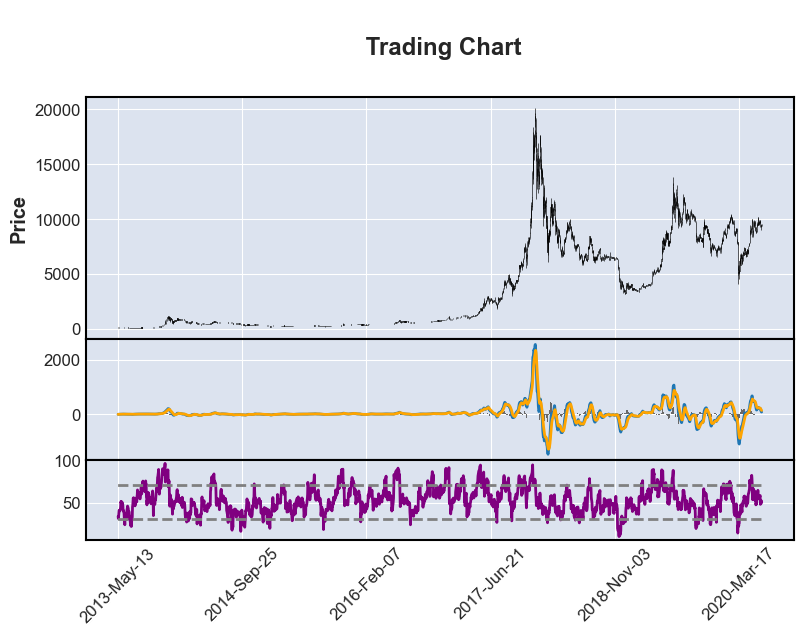

In [6]:
mpf.plot(df.iloc[14:, :],type='candle', addplot=indicators, figscale=1.1,figratio=(8,5),title='\n Trading Chart',panel_ratios=(6,3,2))
plt.show()


now that you know what MACD and RSI is and look like, i propose you to backtest those indicators with all the data available to see and compare the performance of them.

we will use these simple rules:
BUY when the MACD line (blue) crosses over the signal line (orange) and if they have negative values.
SELL when the MACD line crosses below the signal line and if they have positive values.

I will display the result of each trade in a DataFrame for analysis.


## backtesting section of our MACD strategy

In [7]:
cursor = 1
buy_sell_list_macd = []

while cursor < len(df) - 1:
    try:
        while np.sign(histogram.iloc[cursor]) == -1 and signal.iloc[cursor] < 0:
            cursor += 1

        buy_sell_list_macd.append(f"buy at {close_prices.iloc[cursor -1]}")

        while signal.iloc[cursor] < 0:
            cursor += 1

        while np.sign(histogram.iloc[cursor]) == 1: 
            cursor += 1 

        buy_sell_list_macd.append(f"sell at {close_prices.iloc[cursor- 1]}")

        while signal.iloc[cursor] > 0: 
            cursor += 1
            
    except IndexError:
        break
        
print("this is the list of all buy/sell actions that would have been made with the MACD strategy and our set of conditions\n \n",  buy_sell_list_macd)    

this is the list of all buy/sell actions that would have been made with the MACD strategy and our set of conditions
 
 ['buy at 115.0', 'sell at 122.29', 'buy at 107.4', 'sell at 102.8', 'buy at 727.83', 'sell at 833.27', 'buy at 582.69', 'sell at 649.16', 'buy at 588.87', 'sell at 357.84', 'buy at 310.74', 'sell at 290.59', 'buy at 253.7', 'sell at 236.8', 'buy at 228.8', 'sell at 278.09', 'buy at 231.4', 'sell at 380.26', 'buy at 369.95', 'sell at 423.99', 'buy at 587.56', 'sell at 606.97', 'buy at 895.03', 'sell at 988.67', 'buy at 1026.43', 'sell at 2038.87', 'buy at 2273.43', 'sell at 4087.66', 'buy at 3926.07', 'sell at 5930.32', 'buy at 11786.3', 'sell at 9965.57', 'buy at 8728.47', 'sell at 9373.01', 'buy at 7541.45', 'sell at 7780.44', 'buy at 6308.53', 'sell at 6529.17', 'buy at 6519.67', 'sell at 3851.05', 'buy at 10399.67', 'sell at 10895.83', 'buy at 10346.76', 'sell at 8804.88', 'buy at 7424.29', 'sell at 8680.88', 'buy at 6198.78', 'sell at 8756.43']


## Now we are going to display in a DataFrame the wintrade of our MACD strategy as well as the total gain/loss with a starting investment of 100 dollars.

In [27]:
investment = 100
result_macd_df = pd.DataFrame()
result_macd_df['buy'] = [float(item.split(' ')[-1]) for item in buy_sell_list_macd if item.startswith('buy')]
result_macd_df['sell'] = [float(item.split(' ')[-1]) for item in buy_sell_list_macd if item.startswith('sell')]
result_macd_df['gain/loss'] = [(row[1][1]-row[1][0])/row[1][0] for row in result_macd_df.iterrows()]

equity_list = []
for item in range(len(result_macd_df)):
    global investment
    new_investment = investment* (1 + result_macd_df.iloc[item, 2])
    equity_list.append(new_investment)
    investment = new_investment
result_macd_df['equity'] = equity_list

print(result_macd_df)

losing_trades = result_macd_df[result_macd_df['gain/loss'] < 0]
winning_trades = result_macd_df[result_macd_df['gain/loss'] > 0]

win_trade_macd = len(winning_trades)/len(losing_trades)
print(f'\n the wintrade of our MACD strategy is {win_trade_macd} witch means that we won {win_trade_macd} times more than we lost')

         buy      sell  gain/loss      equity
0     115.00    122.29   0.063391  106.339130
1     107.40    102.80  -0.042831  101.784568
2     727.83    833.27   0.144869  116.529996
3     582.69    649.16   0.114074  129.823083
4     588.87    357.84  -0.392328   78.889894
5     310.74    290.59  -0.064845   73.774263
6     253.70    236.80  -0.066614   68.859856
7     228.80    278.09   0.215428   83.694219
8     231.40    380.26   0.643302  137.534847
9     369.95    423.99   0.146074  157.625084
10    587.56    606.97   0.033035  162.832217
11    895.03    988.67   0.104622  179.868080
12   1026.43   2038.87   0.986370  357.284601
13   2273.43   4087.66   0.798014  642.402876
14   3926.07   5930.32   0.510498  970.348115
15  11786.30   9965.57  -0.154479  820.450189
16   8728.47   9373.01   0.073843  881.035030
17   7541.45   7780.44   0.031690  908.955200
18   6308.53   6529.17   0.034975  940.745787
19   6519.67   3851.05  -0.409318  555.681356
20  10399.67  10895.83   0.047709 

Here we are! we can see that with a starting 100 dollars investment, we end up with 818 dollars just by following our simple trading rules. This is a 718% profit. Our strategy isn't perfect and in the futur, we will try to improve our MACD strategy to get better results. Moreover, we will compare our MACD strategy with other famous indicators such as RSI (relative strengh index).

## backtesting section of our RSI strategy

In [8]:
cursor = 0
buy_sell_list_rsi = []

while cursor < len(df) - 1:
    try:
        while indic_df['RSI'].iloc[cursor] > 30:
            cursor += 1
        buy_sell_list_rsi.append(f"buy at {close_prices.iloc[cursor + 14]}")
        
        while indic_df['RSI'].iloc[cursor] < 70:
            cursor += 1
        buy_sell_list_rsi.append(f"sell at {close_prices.iloc[cursor + 14]}")
        
    except IndexError:
        break
        
print("this is the list of all buy/sell actions that would have been made with our RSI strategy and our set of conditions\n \n",  buy_sell_list_rsi) 

this is the list of all buy/sell actions that would have been made with our RSI strategy and our set of conditions
 
 ['buy at 108.3', 'sell at 119.0', 'buy at 605.24', 'sell at 524.58', 'buy at 567.29', 'sell at 423.56', 'buy at 319.78', 'sell at 296.38', 'buy at 219.16', 'sell at 250.9', 'buy at 211.08', 'sell at 254.32', 'buy at 364.33', 'sell at 441.39', 'buy at 547.47', 'sell at 641.07', 'buy at 1998.86', 'sell at 3419.94', 'buy at 3154.95', 'sell at 5446.91', 'buy at 6955.27', 'sell at 9697.5', 'buy at 7135.99', 'sell at 7711.11', 'buy at 5738.35', 'sell at 3947.09', 'buy at 8620.57', 'sell at 8827.76', 'buy at 4970.79', 'sell at 8801.04']


In [26]:
investment = 100
result_rsi_df = pd.DataFrame()
result_rsi_df['buy'] = [float(item.split(' ')[-1]) for item in buy_sell_list_rsi if item.startswith('buy')]
result_rsi_df['sell'] = [float(item.split(' ')[-1]) for item in buy_sell_list_rsi if item.startswith('sell')]
result_rsi_df['gain/loss'] = [(row[1][1]-row[1][0])/row[1][0] for row in result_rsi_df.iterrows()]

equity_list = []
for item in range(len(result_rsi_df)):
    global investment
    new_investment = investment* (1 + result_macd_df.iloc[item, 2])
    equity_list.append(new_investment)
    investment = new_investment
result_rsi_df['equity'] = equity_list

print(result_rsi_df)

losing_trades = result_rsi_df[result_rsi_df['gain/loss'] < 0]
winning_trades = result_rsi_df[result_rsi_df['gain/loss'] > 0]

win_trade_rsi = len(winning_trades)/len(losing_trades)
print(f'\n the wintrade of our RSI strategy is {win_trade_rsi} witch means that we won {win_trade_rsi} times more than we lost')

        buy     sell  gain/loss      equity
0    108.30   119.00   0.098800  106.339130
1    605.24   524.58  -0.133269  101.784568
2    567.29   423.56  -0.253362  116.529996
3    319.78   296.38  -0.073175  129.823083
4    219.16   250.90   0.144826   78.889894
5    211.08   254.32   0.204851   73.774263
6    364.33   441.39   0.211512   68.859856
7    547.47   641.07   0.170968   83.694219
8   1998.86  3419.94   0.710945  137.534847
9   3154.95  5446.91   0.726465  157.625084
10  6955.27  9697.50   0.394267  162.832217
11  7135.99  7711.11   0.080594  179.868080
12  5738.35  3947.09  -0.312156  357.284601
13  8620.57  8827.76   0.024034  642.402876
14  4970.79  8801.04   0.770552  970.348115

 the wintrade of our RSI strategy is 2.75 witch means that we won 2.75 times more than we lost


with our RSI strategy, we see that we get 970 USD with a strating investment of 100 USD. this is a 870% profit. like our MACD strategy, we can improve it to get better results.